In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Import Dataset

In [ ]:
df = pd.read_csv('/content/train.csv', skipinitialspace=True)

In [ ]:
df

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
0,2009,1,1,0,0,0,0,0,0,0.0,5.0,1010,75.34,106.15,0.499,346.1,3.1,0
1,2009,1,1,0,30,0,0,0,0,1.0,5.0,1010,80.81,112.28,0.490,346.1,3.1,0
2,2009,1,1,1,0,0,0,0,4,0.0,5.0,1010,78.27,118.50,0.482,347.9,3.2,0
3,2009,1,1,1,30,0,0,0,4,0.0,4.0,1010,78.27,124.78,0.478,347.9,3.1,0
4,2009,1,1,2,0,0,0,0,4,0.0,4.0,1010,76.45,131.12,0.475,350.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175291,2018,12,31,21,30,51,555,168,4,19.4,20.8,1008,91.77,77.86,3.700,204.0,3.5,100
175292,2018,12,31,22,0,37,388,84,4,19.1,20.1,1008,93.88,83.03,3.800,209.0,3.2,100
175293,2018,12,31,22,30,15,115,18,7,19.1,19.6,1008,96.83,88.32,3.800,208.0,2.6,57
175294,2018,12,31,23,0,0,0,0,7,18.7,19.2,1009,96.84,94.34,3.700,206.0,2.1,0


In [ ]:
df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point',
       'Temperature', 'Pressure', 'Relative Humidity', 'Solar Zenith Angle',
       'Precipitable Water', 'Wind Direction', 'Wind Speed', 'Fill Flag'],
      dtype='object')

In [ ]:
df.isnull().sum()

Year                  0
Month                 0
Day                   0
Hour                  0
Minute                0
Clearsky DHI          0
Clearsky DNI          0
Clearsky GHI          0
Cloud Type            0
Dew Point             0
Temperature           0
Pressure              0
Relative Humidity     0
Solar Zenith Angle    0
Precipitable Water    0
Wind Direction        0
Wind Speed            0
Fill Flag             0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175296 entries, 0 to 175295
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                175296 non-null  int64  
 1   Month               175296 non-null  int64  
 2   Day                 175296 non-null  int64  
 3   Hour                175296 non-null  int64  
 4   Minute              175296 non-null  int64  
 5   Clearsky DHI        175296 non-null  int64  
 6   Clearsky DNI        175296 non-null  int64  
 7   Clearsky GHI        175296 non-null  int64  
 8   Cloud Type          175296 non-null  int64  
 9   Dew Point           175296 non-null  float64
 10  Temperature         175296 non-null  float64
 11  Pressure            175296 non-null  int64  
 12  Relative Humidity   175296 non-null  float64
 13  Solar Zenith Angle  175296 non-null  float64
 14  Precipitable Water  175296 non-null  float64
 15  Wind Direction      175296 non-nul

# Preprocessing

In [ ]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 24.07 MB
Memory usage after optimization is: 5.02 MB
Decreased by 79.2%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175296 entries, 0 to 175295
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                175296 non-null  int16  
 1   Month               175296 non-null  int8   
 2   Day                 175296 non-null  int8   
 3   Hour                175296 non-null  int8   
 4   Minute              175296 non-null  int8   
 5   Clearsky DHI        175296 non-null  int16  
 6   Clearsky DNI        175296 non-null  int16  
 7   Clearsky GHI        175296 non-null  int16  
 8   Cloud Type          175296 non-null  int8   
 9   Dew Point           175296 non-null  float16
 10  Temperature         175296 non-null  float16
 11  Pressure            175296 non-null  int16  
 12  Relative Humidity   175296 non-null  float16
 13  Solar Zenith Angle  175296 non-null  float16
 14  Precipitable Water  175296 non-null  float16
 15  Wind Direction      175296 non-nul

In [ ]:
pred_cols= ['Clearsky DHI','Clearsky DNI','Clearsky GHI']

In [ ]:
df_calculate_cols = df.drop(columns=pred_cols).columns.tolist()

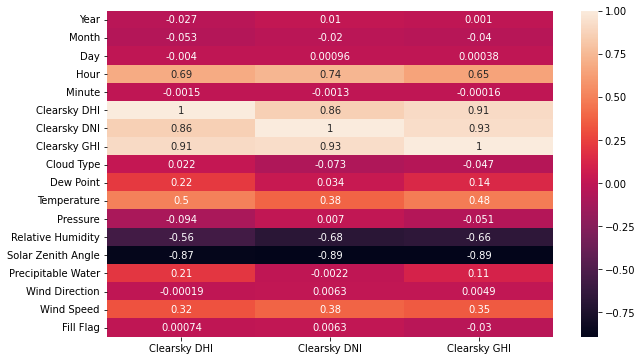

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(df.corr()[pred_cols],annot = True)

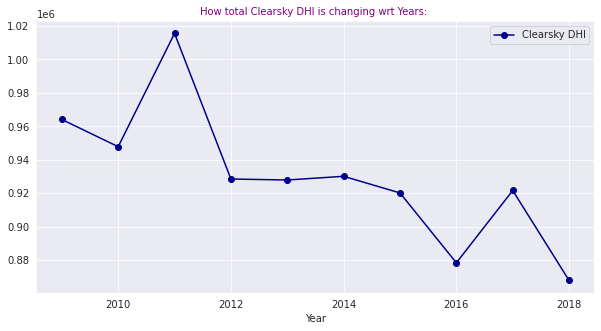

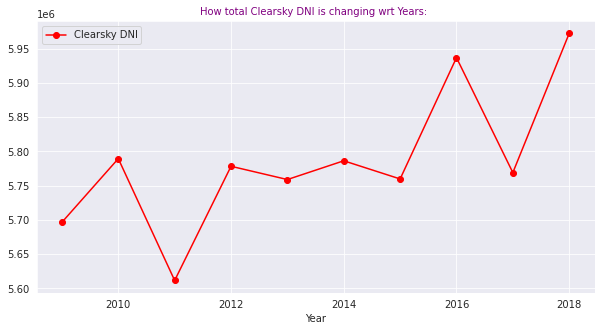

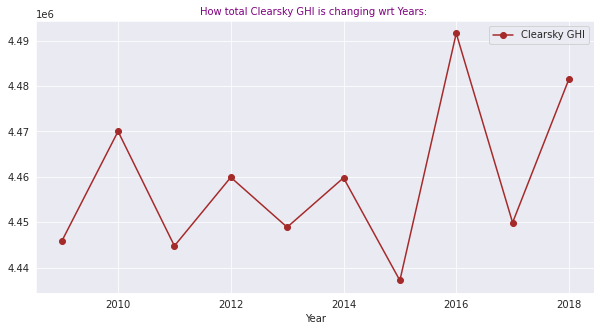

In [ ]:
sns.set_style(style='darkgrid')

df[["Year","Clearsky DHI"]].groupby("Year").agg("sum").plot(marker = 'o',figsize = (10,5),color = "darkblue")
plt.title("How total Clearsky DHI is changing wrt Years: ",color = 'purple',size = 10)

df[["Year","Clearsky DNI"]].groupby("Year").agg("sum").plot(marker = 'o',figsize = (10,5),color = 'r')
plt.title("How total Clearsky DNI is changing wrt Years: ",color = 'purple',size = 10)


df[["Year","Clearsky GHI"]].groupby("Year").agg("sum").plot(marker = 'o',figsize = (10,5),color = 'brown')
plt.title("How total Clearsky GHI is changing wrt Years: ",color = 'purple',size = 10)
plt.show()

In [ ]:
year_2009 = df[df['Year']==2009]

In [ ]:
year_2009['Month'] = year_2009['Month'].apply(lambda x: calendar.month_name[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


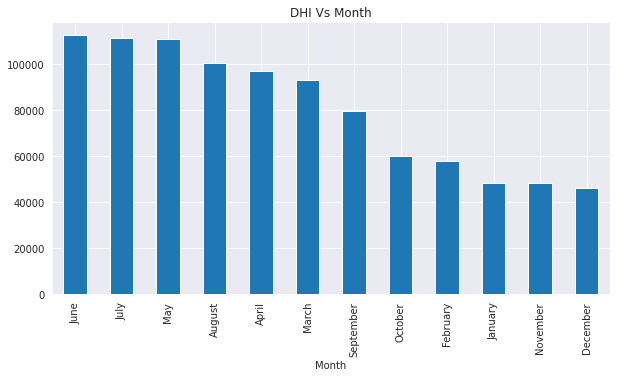

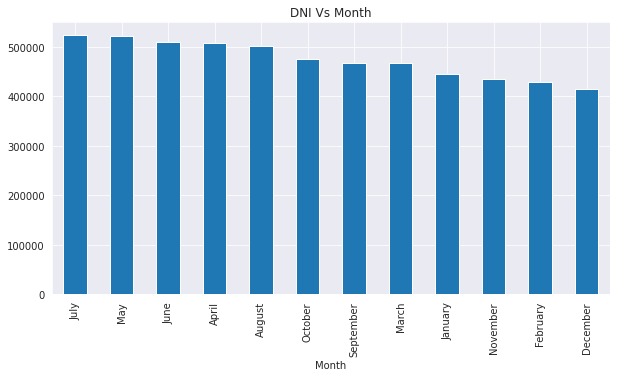

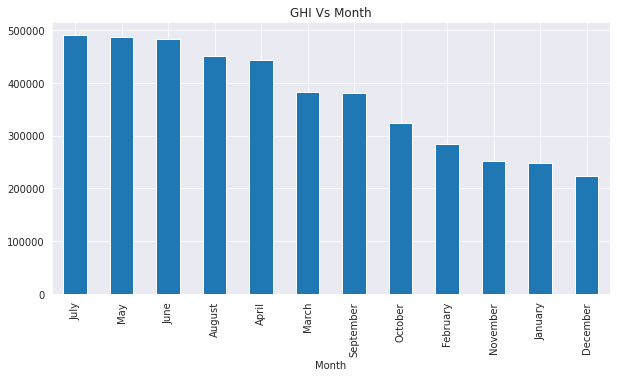

In [ ]:
plt.figure(figsize=(10,5))
year_2009.groupby('Month').sum()['Clearsky DHI'].sort_values(ascending=False).plot(kind='bar')
plt.title('DHI Vs Month')

plt.figure(figsize=(10,5))
year_2009.groupby('Month').sum()['Clearsky DNI'].sort_values(ascending=False).plot(kind='bar')
plt.title('DNI Vs Month')

plt.figure(figsize=(10,5))
year_2009.groupby('Month').sum()['Clearsky GHI'].sort_values(ascending=False).plot(kind='bar')
plt.title('GHI Vs Month')
plt.show()

In [ ]:
X = df.drop(columns=pred_cols)
Y1 = df['Clearsky DHI']
Y2 = df['Clearsky DNI']
Y3 = df['Clearsky GHI']

In [ ]:
X.shape

(175296, 15)

In [ ]:
df_calculate_cols = X.columns.tolist()

In [ ]:
scalar = MinMaxScaler()

In [ ]:
X = X[features]

In [ ]:
X[features] = scalar.fit_transform(X[features])

In [ ]:
X[df_calculate_cols] = scalar.fit_transform(X[df_calculate_cols])

In [ ]:
X

,Year,Month,Day,Hour,Minute,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.387189,0.285714,0.740740,0.733996,0.598811,0.049756,0.961111,0.240309,0.00
1,0.0,0.0,0.0,0.000000,1.0,0.0,0.409964,0.285714,0.740740,0.793257,0.636398,0.048564,0.961111,0.240309,0.00
2,0.0,0.0,0.0,0.043478,0.0,0.4,0.387189,0.285714,0.740740,0.765647,0.674753,0.047501,0.966667,0.248031,0.00
3,0.0,0.0,0.0,0.043478,1.0,0.4,0.387189,0.265306,0.740740,0.765647,0.713108,0.046985,0.966667,0.240309,0.00
4,0.0,0.0,0.0,0.086957,0.0,0.4,0.387189,0.265306,0.740740,0.746117,0.752229,0.046599,0.972222,0.232586,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175291,1.0,1.0,1.0,0.913043,1.0,0.4,0.829181,0.608099,0.703703,0.911107,0.425448,0.472101,0.566667,0.271351,1.00
175292,1.0,1.0,1.0,0.956522,0.0,0.4,0.822064,0.593750,0.703703,0.934004,0.456899,0.485505,0.580556,0.248031,1.00
175293,1.0,1.0,1.0,0.956522,1.0,0.7,0.822064,0.583546,0.703703,0.965655,0.489500,0.485505,0.577778,0.201545,0.57
175294,1.0,1.0,1.0,1.000000,0.0,0.7,0.813167,0.575574,0.722221,0.965655,0.526321,0.472101,0.572222,0.162780,0.00


In [ ]:
X1_train,X1_test,y1_train,y1_test = train_test_split(X,Y1,test_size=0.25,random_state=142)

X2_train,X2_test,y2_train,y2_test = train_test_split(X,Y2,test_size=0.25,random_state=50)

X3_train,X3_test,y3_train,y3_test = train_test_split(X,Y3,test_size=0.25,random_state=85)

In [ ]:
print(X1_train.shape)
print(y1_train.shape)
print(X1_test.shape)
print(y1_test.shape)
print(X2_train.shape)
print(y2_train.shape)
print(X2_test.shape)
print(y2_test.shape)
print(X3_train.shape)
print(y3_train.shape)
print(X3_test.shape)
print(y3_test.shape)

(131472, 15)
(131472,)
(43824, 15)
(43824,)
(131472, 15)
(131472,)
(43824, 15)
(43824,)
(131472, 15)
(131472,)
(43824, 15)
(43824,)


# Models


In [ ]:
def model_eval(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    return mse

## Model 1

In [ ]:
def test_params(**params):
    model = XGBRegressor(n_jobs = -1, random_state = 12, **params)
    print("DHI_MSE :",model_eval(model,X1_train,X1_test,y1_train,y1_test))
    print("DNI_MSE :",model_eval(model,X2_train,X2_test,y2_train,y2_test))
    print("GHI_MSE :",model_eval(model,X3_train,X3_test,y3_train,y3_test))

In [ ]:
test_params()

[07:03:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
DHI_MSE : 242.9193
[07:03:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
DNI_MSE : 1551.2878
[07:03:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GHI_MSE : 60.34184


## Model 2

In [ ]:
def test_params(**params):
    model = RandomForestRegressor(n_jobs = -1, random_state = 42, **params)
    print("DHI_MSE :",model_eval(model,X1_train,X1_test,y1_train,y1_test))
    print("DNI_MSE :",model_eval(model,X2_train,X2_test,y2_train,y2_test))
    print("GHI_MSE :",model_eval(model,X3_train,X3_test,y3_train,y3_test))

In [ ]:
test_params()

DHI_MSE : 101.69236608707558
DNI_MSE : 1089.9821751346294
GHI_MSE : 39.827427528295


## Model 3

In [ ]:
def test_params(**params):
    model = LGBMRegressor(n_jobs = -1, random_state = 42, **params)
    print("DHI_MSE :",model_eval(model,X1_train,X1_test,y1_train,y1_test))
    print("DNI_MSE :",model_eval(model,X2_train,X2_test,y2_train,y2_test))
    print("GHI_MSE :",model_eval(model,X3_train,X3_test,y3_train,y3_test))

In [ ]:
test_params()

DHI_MSE : 167.22513790597444
DNI_MSE : 1107.1558566453966
GHI_MSE : 37.11948615516295


## Selected Model

In [ ]:
model1 = LGBMRegressor(n_jobs = -1, random_state = 42, n_estimators=4000,learning_rate=0.2,max_depth=10)

In [ ]:
model1.fit(X1_train,y1_train)

LGBMRegressor(learning_rate=0.2, max_depth=10, n_estimators=4000,
              random_state=42)

In [ ]:
model2 = LGBMRegressor(n_jobs = -1, random_state = 42, n_estimators=4000,learning_rate=0.2, max_depth=10)

In [ ]:
model2.fit(X2_train,y2_train)

LGBMRegressor(learning_rate=0.2, max_depth=10, n_estimators=4000,
              random_state=42)

In [ ]:
model3 = LGBMRegressor(n_jobs = -1, random_state = 42, n_estimators=4000,learning_rate=0.2, max_depth=10)

In [ ]:
model3.fit(X3_train,y3_train)

LGBMRegressor(learning_rate=0.2, max_depth=10, n_estimators=4000,
              random_state=42)

## Prediction

In [ ]:
def mse(y_test, y_pred):
  mse = mean_squared_error(y_test,y_pred)
  return mse

### Custom Input

In [ ]:
new_input = {
    'Year':[2022,2023],
    'Month':[10,11],
    'Day':[15,16],
    'Hour':[10,11],
    'Minute':[30,0],
    'Cloud Type':[4,0],
    'Dew Point':[1.0,0.0],
    'Temperature':[5.0,4.0],
    'Pressure':[1010,1000],
    'Relative Humidity':[75.2,70.3],
    'Solar Zenith Angle':[120.0,160.5],
    'Precipitable Water':[0.470,0.50],
    'Wind Direction':[360.0,250.6],
    'Wind Speed':[5.0,10.5],
    'Fill Flag':[1,0]
}

In [ ]:
def predict(model, new_input):
    input_df = pd.DataFrame(new_input)
    input_cols = input_df.columns.tolist()
    input_df[input_cols] = scalar.fit_transform(input_df [input_cols])
    return model.predict(input_df)

In [ ]:
print("DHI = ",predict(model1,new_input))

DHI =  [182.98369404  51.79171512]


In [ ]:
print("DNI = ",predict(model2,new_input))

DNI =  [870.21970116 -79.80536954]


In [ ]:
print("GHI = ",predict(model3,new_input))

GHI =  [1020.53713436  -13.8906228 ]


### Test Data Prediction

In [ ]:
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df_test.drop(columns=pred_cols, inplace=True)

In [ ]:
pred_dhi = predict(model1, df_test)

In [ ]:
pred_dni = predict(model2, df_test)

In [ ]:
pred_ghi = predict(model3, df_test)

In [ ]:
pred_cols

['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']

In [ ]:
pred_df = pd.DataFrame()

In [ ]:
pred_df['Clearsky DHI'] = pred_dhi
pred_df['Clearsky DNI'] = pred_dni
pred_df['Clearsky GHI'] = pred_ghi

In [ ]:
pred_df

,Clearsky DHI,Clearsky DNI,Clearsky GHI
0,-2.069542,-2.760045,-2.416841
1,-1.867836,-2.237985,-2.520705
2,-1.220629,-1.680550,-2.043858
3,-1.765505,-6.193044,-2.681900
4,-2.634625,-3.117712,-2.110423
...,...,...,...
17515,47.003669,661.035777,186.651608
17516,30.409471,479.375483,97.133145
17517,12.073723,177.053591,16.446673
17518,-1.600976,-13.640920,-1.223017


## Feature Selection

In [ ]:
featue_importance_DHI = pd.DataFrame({
  'feature': X.columns,
  'importance': model1.feature_importances_
}).sort_values('importance', ascending=False)

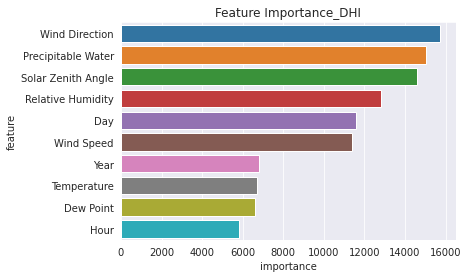

In [ ]:
plt.title('Feature Importance_DHI')
sns.barplot(data=featue_importance_DHI.head(10), x='importance', y='feature');

In [ ]:
featue_importance_DNI = pd.DataFrame({
  'feature': X.columns,
  'importance': model2.feature_importances_
}).sort_values('importance', ascending=False)

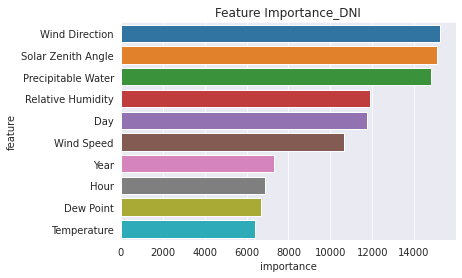

In [ ]:
plt.title('Feature Importance_DNI')
sns.barplot(data=featue_importance_DNI.head(10), x='importance', y='feature');

In [ ]:
featue_importance_GHI = pd.DataFrame({
  'feature': X.columns,
  'importance': model3.feature_importances_
}).sort_values('importance', ascending=False)

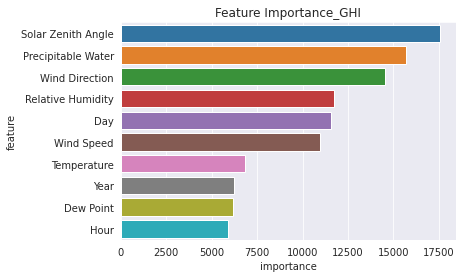

In [ ]:
plt.title('Feature Importance_GHI')
sns.barplot(data=featue_importance_GHI.head(10), x='importance', y='feature');

## Model Selection And Tuning

In [ ]:
 # pip install flaml

In [ ]:
from flaml import AutoML

In [ ]:
features = ['Precipitable Water', 'Wind Direction', 'Wind Speed', 
           'Relative Humidity', 'Solar Zenith Angle', 'Day']

In [ ]:
X = X[features]

In [ ]:
X1_train,X1_test,y1_train,y1_test = train_test_split(X,Y1,test_size=0.25,random_state=142)

X2_train,X2_test,y2_train,y2_test = train_test_split(X,Y2,test_size=0.25,random_state=50)

X3_train,X3_test,y3_train,y3_test = train_test_split(X,Y3,test_size=0.25,random_state=85)

### DHI Model

In [ ]:
modelDHI = AutoML()
automl_settings = {
    "time_budget": 150,  # in seconds
    "metric": 'mse',
    "task": 'regression'
}

In [ ]:
# Train with labeled input data
modelDHI.fit(X_train=X1_train, y_train=y1_train, **automl_settings)

[flaml.automl: 02-08 12:02:06] {2051} INFO - task = regression
[flaml.automl: 02-08 12:02:06] {2053} INFO - Data split method: uniform
[flaml.automl: 02-08 12:02:06] {2057} INFO - Evaluation method: holdout
[flaml.automl: 02-08 12:02:06] {2138} INFO - Minimizing error metric: mse
[flaml.automl: 02-08 12:02:06] {2196} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 02-08 12:02:06] {2449} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-08 12:02:06] {2563} INFO - Estimated sufficient time budget=6629s. Estimated necessary time budget=47s.
[flaml.automl: 02-08 12:02:06] {2615} INFO -  at 0.2s,	estimator lgbm's best error=2046.2826,	best estimator lgbm's best error=2046.2826
[flaml.automl: 02-08 12:02:06] {2449} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-08 12:02:06] {2615} INFO -  at 0.3s,	estimator lgbm's best error=2046.2826,	best estimator lgbm's best error=2046.2826
[flaml.automl: 02-08 12:02:

KeyboardInterrupt: ignored

In [ ]:
pred_DHI = modelDHI.model.predict(X1_test)
print(pred_DHI.shape)

(43824,)


In [ ]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
print('max error value :',max_error(y1_test,pred_DHI))
print('mean absolute error value :',mean_absolute_error(y1_test,pred_DHI))
print('mean squared error :', mean_squared_error(y1_test,pred_DHI))
print("r2 score :" ,r2_score(y1_test,pred_DHI))

max error value : 103.70018
mean absolute error value : 3.7758467
mean squared error : 45.631405
r2 score : 0.988930960949553


In [ ]:
# Export the best model
print(modelDHI.model)

In [ ]:
print('Best ML leaner:', modelDHI.best_estimator)
print('Best hyperparmeter config:', modelDHI.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-modelDHI.best_loss))
print('Training duration of best run: {0:.4g} s'.format(modelDHI.best_config_train_time))

Best ML leaner: xgboost
Best hyperparmeter config: {'n_estimators': 1183, 'max_leaves': 175, 'min_child_weight': 128.0, 'learning_rate': 0.22099231496115415, 'subsample': 0.836596029972893, 'colsample_bylevel': 0.7820733098381093, 'colsample_bytree': 0.6152784768179972, 'reg_alpha': 5.173540453657851, 'reg_lambda': 0.021921613436247142, 'FLAML_sample_size': 118324}
Best accuracy on validation data: -50.82
Training duration of best run: 65.69 s


#### DHI Tuning

In [ ]:
modelDHI.fit(X1_train, y1_train, task="regression", estimator_list=['lgbm'], metric = 'mse', time_budget=200)

[flaml.automl: 02-08 12:03:17] {2051} INFO - task = regression
[flaml.automl: 02-08 12:03:17] {2053} INFO - Data split method: uniform
[flaml.automl: 02-08 12:03:17] {2057} INFO - Evaluation method: holdout
[flaml.automl: 02-08 12:03:17] {2138} INFO - Minimizing error metric: mse
[flaml.automl: 02-08 12:03:17] {2196} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 02-08 12:03:17] {2449} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-08 12:03:17] {2563} INFO - Estimated sufficient time budget=3679s. Estimated necessary time budget=4s.
[flaml.automl: 02-08 12:03:17] {2615} INFO -  at 0.2s,	estimator lgbm's best error=2046.2826,	best estimator lgbm's best error=2046.2826
[flaml.automl: 02-08 12:03:17] {2449} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-08 12:03:17] {2615} INFO -  at 0.3s,	estimator lgbm's best error=2046.2826,	best estimator lgbm's best error=2046.2826
[flaml.automl: 02-08 12:03:17] {2449} INFO - iteration 2, current learner lgb

In [ ]:
model_optimized_DHI = LGBMRegressor(colsample_bytree=0.8892260067743469,
              learning_rate=0.06105633814806839, max_bin=1023,
              min_child_samples=2, n_estimators=351, num_leaves=718,
              reg_alpha=0.002777631806545659, reg_lambda=0.064674503733867,
              verbose=-1)

In [ ]:
model_optimized_DHI.fit(X1_train, y1_train)

LGBMRegressor(colsample_bytree=0.8892260067743469,
              learning_rate=0.06105633814806839, max_bin=1023,
              min_child_samples=2, n_estimators=351, num_leaves=718,
              reg_alpha=0.002777631806545659, reg_lambda=0.064674503733867,
              verbose=-1)

In [ ]:
pred_optimized_DHI = model_optimized_DHI.predict(X1_test)
print(pred_optimized_DHI.shape)

(43824,)


In [ ]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
print('max error value :',max_error(y1_test,pred_optimized_DHI))
print('mean absolute error value :',mean_absolute_error(y1_test,pred_optimized_DHI))
print('mean squared error :', mean_squared_error(y1_test,pred_optimized_DHI))
print("r2 score :" ,r2_score(y1_test,pred_optimized_DHI))

max error value : 154.66442921623042
mean absolute error value : 5.345413486050518
mean squared error : 115.44117353881734
r2 score : 0.9719968541376434


### DNI Model

In [ ]:
modelDNI = AutoML()
automl_settings = {
    "time_budget": 150,  # in seconds
    "metric": 'mse',
    "task": 'regression'
}

In [ ]:
# Train with labeled input data
modelDNI.fit(X_train=X2_train, y_train=y2_train, **automl_settings)

[flaml.automl: 02-08 12:08:00] {2051} INFO - task = regression
[flaml.automl: 02-08 12:08:00] {2053} INFO - Data split method: uniform
[flaml.automl: 02-08 12:08:00] {2057} INFO - Evaluation method: holdout
[flaml.automl: 02-08 12:08:00] {2138} INFO - Minimizing error metric: mse
[flaml.automl: 02-08 12:08:00] {2196} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 02-08 12:08:00] {2449} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-08 12:08:00] {2563} INFO - Estimated sufficient time budget=3212s. Estimated necessary time budget=23s.
[flaml.automl: 02-08 12:08:00] {2615} INFO -  at 0.2s,	estimator lgbm's best error=62299.3754,	best estimator lgbm's best error=62299.3754
[flaml.automl: 02-08 12:08:00] {2449} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-08 12:08:00] {2615} INFO -  at 0.3s,	estimator lgbm's best error=62299.3754,	best estimator lgbm's best error=62299.3754
[flaml.automl: 02-08 12

KeyboardInterrupt: ignored

In [ ]:
pred_DNI = modelDNI.model.predict(X2_test)
print(pred_DNI.shape)

(43824,)


In [ ]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
print('max error value :',max_error(y2_test,pred_DNI))
print('mean absolute error value :',mean_absolute_error(y2_test,pred_DNI))
print('mean squared error :', mean_squared_error(y2_test,pred_DNI))
print("r2 score :" ,r2_score(y2_test,pred_DNI))

max error value : 253.61362816922667
mean absolute error value : 9.752599891533281
mean squared error : 371.1727131779476
r2 score : 0.9972826539146523


In [ ]:
# Export the best model
print(modelDNI.model)

In [ ]:
print('Best ML leaner:', modelDNI.best_estimator)
print('Best hyperparmeter config:', modelDNI.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-modelDNI.best_loss))
print('Training duration of best run: {0:.4g} s'.format(modelDNI.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 1240, 'num_leaves': 259, 'min_child_samples': 2, 'learning_rate': 0.18263755586565553, 'log_max_bin': 8, 'colsample_bytree': 0.8373169487910703, 'reg_alpha': 0.0012336818747802404, 'reg_lambda': 0.06540594775309745, 'FLAML_sample_size': 118324}
Best accuracy on validation data: -404.8
Training duration of best run: 22.99 s


In [ ]:
modelDNI.fit(X2_train, y2_train, task="regression", estimator_list=['lgbm'], metric = 'mse', time_budget=200)

[flaml.automl: 02-08 12:08:36] {2051} INFO - task = regression
[flaml.automl: 02-08 12:08:36] {2053} INFO - Data split method: uniform
[flaml.automl: 02-08 12:08:36] {2057} INFO - Evaluation method: holdout
[flaml.automl: 02-08 12:08:36] {2138} INFO - Minimizing error metric: mse
[flaml.automl: 02-08 12:08:36] {2196} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 02-08 12:08:36] {2449} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-08 12:08:36] {2563} INFO - Estimated sufficient time budget=3030s. Estimated necessary time budget=3s.
[flaml.automl: 02-08 12:08:36] {2615} INFO -  at 0.2s,	estimator lgbm's best error=62299.3754,	best estimator lgbm's best error=62299.3754
[flaml.automl: 02-08 12:08:36] {2449} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-08 12:08:36] {2615} INFO -  at 0.3s,	estimator lgbm's best error=62299.3754,	best estimator lgbm's best error=62299.3754
[flaml.automl: 02-08 12:08:36] {2449} INFO - iteration 2, current learner

In [ ]:
model_optimized_DNI =  LGBMRegressor(colsample_bytree=0.6155210339177122,
              learning_rate=0.095883308367604, max_bin=1023,
              min_child_samples=6, n_estimators=4611, num_leaves=294,
              reg_alpha=0.0009765625, reg_lambda=0.0027363531098949703,
              verbose=-1)

In [ ]:
model_optimized_DNI.fit(X2_train, y2_train)

LGBMRegressor(colsample_bytree=0.6155210339177122,
              learning_rate=0.095883308367604, max_bin=1023,
              min_child_samples=6, n_estimators=4611, num_leaves=294,
              reg_alpha=0.0009765625, reg_lambda=0.0027363531098949703,
              verbose=-1)

In [ ]:
pred_optimized_DNI = model_optimized_DNI.predict(X2_test)
print(pred_optimized_DHI.shape)

(43824,)


In [ ]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
print('max error value :',max_error(y2_test,pred_optimized_DNI))
print('mean absolute error value :',mean_absolute_error(y2_test,pred_optimized_DNI))
print('mean squared error :', mean_squared_error(y2_test,pred_optimized_DNI))
print("r2 score :" ,r2_score(y2_test,pred_optimized_DNI))

max error value : 387.6266310911584
mean absolute error value : 20.162755644895963
mean squared error : 1194.7997466721142
r2 score : 0.9912529011451408


### GHI Model

In [ ]:
modelGHI = AutoML()
automl_settings = {
    "time_budget": 300,  # in seconds
    "metric": 'mse',
    "task": 'regression'
}

In [ ]:
# Train with labeled input data
modelGHI.fit(X_train=X3_train, y_train=y3_train, **automl_settings)

[flaml.automl: 02-08 10:12:36] {2051} INFO - task = regression
[flaml.automl: 02-08 10:12:36] {2053} INFO - Data split method: uniform
[flaml.automl: 02-08 10:12:36] {2057} INFO - Evaluation method: holdout
[flaml.automl: 02-08 10:12:36] {2138} INFO - Minimizing error metric: mse
[flaml.automl: 02-08 10:12:36] {2196} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 02-08 10:12:36] {2449} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-08 10:12:36] {2563} INFO - Estimated sufficient time budget=3938s. Estimated necessary time budget=28s.
[flaml.automl: 02-08 10:12:36] {2615} INFO -  at 0.4s,	estimator lgbm's best error=47961.7895,	best estimator lgbm's best error=47961.7895
[flaml.automl: 02-08 10:12:36] {2449} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-08 10:12:36] {2615} INFO -  at 0.4s,	estimator lgbm's best error=47961.7895,	best estimator lgbm's best error=47961.7895
[flaml.automl: 02-08 10

In [ ]:
pred_GHI = modelGHI.model.predict(X3_test)
print(pred_GHI.shape)

(43824,)


In [ ]:
# Export the best model
print(modelGHI.model)

In [ ]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
print('max error value :',max_error(y3_test,pred_GHI))
print('mean absolute error value :',mean_absolute_error(y3_test,pred_GHI))
print('mean squared error :', mean_squared_error(y3_test,pred_GHI))
print("r2 score :" ,r2_score(y3_test,pred_GHI))

max error value : 58.394226
mean absolute error value : 2.5007734
mean squared error : 17.65078
r2 score : 0.9998353942600148


In [ ]:
print('Best ML leaner:', modelGHI.best_estimator)
print('Best hyperparmeter config:', modelGHI.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-modelGHI.best_loss))
print('Training duration of best run: {0:.4g} s'.format(modelGHI.best_config_train_time))

Best ML leaner: xgboost
Best hyperparmeter config: {'n_estimators': 442, 'max_leaves': 780, 'min_child_weight': 94.8726411978938, 'learning_rate': 0.08727546789327977, 'subsample': 0.8809985595678514, 'colsample_bylevel': 0.8490633393816673, 'colsample_bytree': 0.7521390195924419, 'reg_alpha': 0.079541680346307, 'reg_lambda': 0.6308915942549503, 'FLAML_sample_size': 118324}
Best accuracy on validation data: -16.41
Training duration of best run: 46.51 s


#### GHI Tuning

In [ ]:
modelGHI.fit(X3_train, y3_train, task="regression", estimator_list=['lgbm'], metric = 'mse', time_budget=200)

[flaml.automl: 02-08 12:16:55] {2051} INFO - task = regression
[flaml.automl: 02-08 12:16:55] {2053} INFO - Data split method: uniform
[flaml.automl: 02-08 12:16:55] {2057} INFO - Evaluation method: holdout
[flaml.automl: 02-08 12:16:55] {2138} INFO - Minimizing error metric: mse
[flaml.automl: 02-08 12:16:55] {2196} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 02-08 12:16:55] {2449} INFO - iteration 0, current learner lgbm
[flaml.automl: 02-08 12:16:55] {2563} INFO - Estimated sufficient time budget=2908s. Estimated necessary time budget=3s.
[flaml.automl: 02-08 12:16:55] {2615} INFO -  at 0.2s,	estimator lgbm's best error=47961.7895,	best estimator lgbm's best error=47961.7895
[flaml.automl: 02-08 12:16:55] {2449} INFO - iteration 1, current learner lgbm
[flaml.automl: 02-08 12:16:55] {2615} INFO -  at 0.2s,	estimator lgbm's best error=47961.7895,	best estimator lgbm's best error=47961.7895
[flaml.automl: 02-08 12:16:55] {2449} INFO - iteration 2, current learner

In [ ]:
model_optimized_GHI = LGBMRegressor(colsample_bytree=0.9808223171534735,
              learning_rate=0.06206010982049826, max_bin=1023,
              min_child_samples=8, n_estimators=5284, num_leaves=189,
              reg_alpha=0.001975258376030875, reg_lambda=0.021619049836875993,
              verbose=-1)

In [ ]:
model_optimized_GHI.fit(X3_train, y3_train)

LGBMRegressor(colsample_bytree=0.9808223171534735,
              learning_rate=0.06206010982049826, max_bin=1023,
              min_child_samples=8, n_estimators=5284, num_leaves=189,
              reg_alpha=0.001975258376030875, reg_lambda=0.021619049836875993,
              verbose=-1)

In [ ]:
pred_optimized_GHI = model_optimized_GHI.predict(X3_test)
print(pred_optimized_GHI.shape)

(43824,)


In [ ]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
print('max error value :',max_error(y3_test,pred_optimized_GHI))
print('mean absolute error value :',mean_absolute_error(y3_test,pred_optimized_GHI))
print('mean squared error :', mean_squared_error(y3_test,pred_optimized_GHI))
print("r2 score :" ,r2_score(y3_test,pred_optimized_GHI))

max error value : 53.51551337754438
mean absolute error value : 3.1247051346587686
mean squared error : 35.476950072641706
r2 score : 0.9996691528630178


## Model Save

In [ ]:
import pickle

### Saving Scaling Model

In [ ]:
filename = 'Scalar_model.sav'
pickle.dump(scalar, open(filename, 'wb'))

### Saving DHI Model

In [ ]:
filename = 'Final_DHI_model.sav'
pickle.dump(model_optimized_DHI, open(filename, 'wb'))

### Saving DNI Model

In [ ]:
filename = 'Final_DNI_model.sav'
pickle.dump(model_optimized_DNI, open(filename, 'wb'))

### Saving GHI Model

In [ ]:
filename = 'Final_GHI_model.sav'
pickle.dump(model_optimized_GHI, open(filename, 'wb'))

## Predicting Test Data

In [ ]:
def predict(model, new_input):
    input_df = pd.DataFrame(new_input)
    input_cols = input_df.columns.tolist()
    input_df[input_cols] = scalar.fit_transform(input_df [input_cols])
    return model.predict(input_df)

In [ ]:
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df_test.drop(columns=pred_cols, inplace=True)

In [ ]:
df_test = df_test[features]

In [ ]:
pred_dhi = predict(model_optimized_GHI, df_test)

In [ ]:
pred_dni = predict(model_optimized_GHI, df_test)

In [ ]:
pred_ghi = predict(model_optimized_GHI, df_test)

In [ ]:
pred_df = pd.DataFrame()

In [ ]:
pred_df['Clearsky DHI'] = pred_dhi
pred_df['Clearsky DNI'] = pred_dni
pred_df['Clearsky GHI'] = pred_ghi

In [ ]:
pred_df.to_csv('my_submission2.csv', index=False)

In [ ]:
pred_df

,Clearsky DHI,Clearsky DNI,Clearsky GHI
0,0.156593,0.156593,0.156593
1,0.106353,0.106353,0.106353
2,0.107504,0.107504,0.107504
3,0.740587,0.740587,0.740587
4,0.473241,0.473241,0.473241
...,...,...,...
17515,185.728809,185.728809,185.728809
17516,95.764430,95.764430,95.764430
17517,19.614415,19.614415,19.614415
17518,-0.248649,-0.248649,-0.248649


In [ ]:
df_test = pd.read_csv('test.csv')

In [ ]:
df_test.drop(columns=pred_cols, inplace=True)

In [ ]:
df_test = df_test[features]

In [ ]:
df_test[features] = scalar.fit_transform(df_test[features])

In [ ]:
pred_dhi = model_optimized_DHI.predict(df_test)

In [ ]:
pred_dni = model_optimized_DNI.predict(df_test)

In [ ]:
pred_ghi = model_optimized_GHI.predict(df_test)

In [ ]:
result = { 'Clearsky DHI': pred_dhi, 'Clearsky DNI': pred_dni, 'Clearsky GHI': pred_ghi } 
pred_df = pd.DataFrame(result)

In [ ]:
pred_df.to_csv('my_submission_file3.csv', index=False)